# Application to toy model with unknown variance

The purpose of this notebook is to verify that the algorithm works when applied with unknown variance.

## Preparation

In [1]:
import pyabc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import copy
import logging
import pickle

df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Acceptor')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Epsilon')
df_logger.setLevel(logging.DEBUG)


std = 0.5
noise_model = np.random.randn
n_t = 5

def model(p):
    return {'y0': p['p0']}

def model_noisy(p):
    return {'y0': model(p)['y0'] + std * noise_model(n_t)}

def model_noisy_uvar(p):
    return {'y0': model(p)['y0'] + p['std'] * noise_model(n_t)}

limits = {'p0': (1, 4)}
prior = pyabc.Distribution(**{key: pyabc.RV('uniform', a, b-a) 
                              for key, (a,b) in limits.items()})
p_true = {'p0': 2.5}

limits_uvar = copy.deepcopy(limits)
limits_uvar['std'] = (0.1, 1.2)

prior_uvar = pyabc.Distribution(**{key: pyabc.RV('uniform', a, b-a) 
                              for key, (a,b) in limits_uvar.items()})

p_true_uvar = copy.deepcopy(p_true)
p_true_uvar['std'] = std

def get_data():
    try:
        data = pickle.load(open(f"data_{n_t}.dat", 'rb'))
    except:
        data = {'y0': 2.5 + std * noise_model(n_t)}
        pickle.dump(data, open(f"data_{n_t}.dat", 'wb'))
    return data

data = get_data()

acceptor = pyabc.StochasticAcceptor()
temperature = pyabc.Temperature()
distance = lambda x, x0: np.sum((x['y0']-x0['y0'])**2)
kernel = pyabc.IndependentNormalKernel(var=np.array(std**2))
def fvar(p):
    return p['std']**2 * np.ones(len(data['y0']))
kernel_uvar = pyabc.IndependentNormalKernel(var=fvar)
pop_size = 1000

def plot(h, ax=None, x='p0', limits=limits, p_true=p_true):
    if ax is None:
        _, ax = plt.subplots()
    for t in reversed(range(0, h.max_t + 1)):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, t=t, x=x, xmin=limits[x][0], xmax=limits[x][1], ax=ax,
            refval=p_true, label=f"Iter. {t}")
    ax.legend()
    return ax

def plot_uvar(h, arr_ax=None):
    if arr_ax is None:
        _, arr_ax = plt.subplots(1, 2)
    plot(h, arr_ax[0], 'p0', limits_uvar, p_true_uvar)
    plot(h, arr_ax[1], 'std', limits_uvar, p_true_uvar)

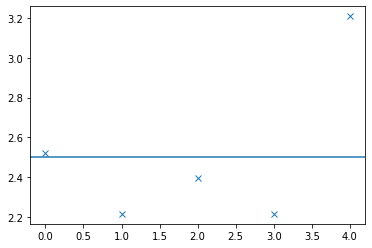

In [2]:
plt.plot(data['y0'], 'x')
plt.axhline(p_true['p0'])

## Known variance

### Incorrect standard ABC

In [3]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=pop_size)
abc.new("sqlite:///h_incorrect.db", data)
h_incorrect = abc.run(max_nr_populations=15)

DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1
INFO:History:Start <ABCSMC(id=1, start_time=2020-01-28 21:56:39.414127, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 3.3769024783019894
INFO:ABC:t: 0, eps: 3.3769024783019894.
INFO:ABC:Acceptance rate: 1000 / 2098 = 4.7664e-01, ESS=1.0000e+03.
DEBUG:Epsilon:new eps, t=1, eps=1.3186266343698367
INFO:ABC:t: 1, eps: 1.3186266343698367.
INFO:ABC:Acceptance rate: 1000 / 1971 = 5.0736e-01, ESS=9.9800e+02.
DEBUG:Epsilon:new eps, t=2, eps=0.8491858564851663
INFO:ABC:t: 2, eps: 0.8491858564851663.
INFO:ABC:Acceptance rate: 1000 / 1892 = 5.2854e-01, ESS=9.9757e+02.
DEBUG:Epsilon:new eps, t=3, eps=0.7162665745326344
INFO:ABC:t: 3, eps: 0.7162665745326344.
INFO:ABC:Acceptance rate: 1000 / 2028 = 4.9310e-01, ESS=9.9909e+02.
DEBUG:Epsilon:new eps, t=4, eps=0.6874662587851766
INFO:ABC:t: 4, eps: 0.6874662587851766.
INFO:ABC:Acceptance rate: 1000 / 1982 = 5.0454e-01, ESS=9.

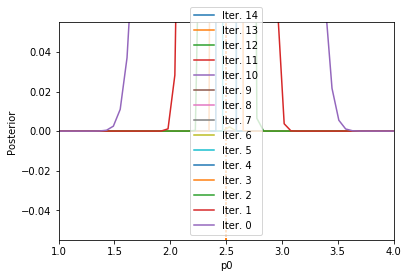

In [4]:
h_incorrect = pyabc.History("sqlite:///h_incorrect.db")
plot(h_incorrect)

### Noisy model

In [5]:
abc = pyabc.ABCSMC(model_noisy, prior, distance, population_size=pop_size)
abc.new("sqlite:///h_noisy_model.db", data)
h_noisy_model = abc.run(max_nr_populations=8)

# note: this cell may need to be stopped if late iterations take too long

DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1
INFO:History:Start <ABCSMC(id=1, start_time=2020-01-28 21:57:40.029904, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 4.7137648969417985
INFO:ABC:t: 0, eps: 4.7137648969417985.
INFO:ABC:Acceptance rate: 1000 / 1968 = 5.0813e-01, ESS=1.0000e+03.
DEBUG:Epsilon:new eps, t=1, eps=2.5733106963680843
INFO:ABC:t: 1, eps: 2.5733106963680843.
INFO:ABC:Acceptance rate: 1000 / 2263 = 4.4189e-01, ESS=9.6656e+02.
DEBUG:Epsilon:new eps, t=2, eps=1.5944728318038583
INFO:ABC:t: 2, eps: 1.5944728318038583.
INFO:ABC:Acceptance rate: 1000 / 3521 = 2.8401e-01, ESS=8.1767e+02.
DEBUG:Epsilon:new eps, t=3, eps=1.1138405354102836
INFO:ABC:t: 3, eps: 1.1138405354102836.
INFO:ABC:Acceptance rate: 1000 / 5596 = 1.7870e-01, ESS=8.1972e+02.
DEBUG:Epsilon:new eps, t=4, eps=0.7960038243576265
INFO:ABC:t: 4, eps: 0.7960038243576265.
INFO:ABC:Acceptance rate: 1000 / 10335 = 9.6759e-02, ESS=8

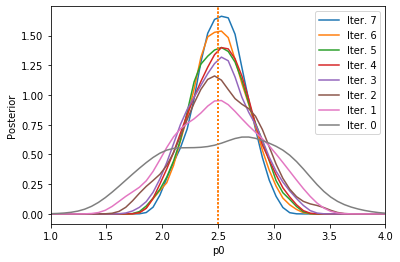

In [6]:
h_noisy_model = pyabc.History("sqlite:///h_noisy_model.db")
plot(h_noisy_model)

### Stochastic acceptor

In [7]:
abc = pyabc.ABCSMC(model, prior, kernel, eps=temperature, acceptor=acceptor, population_size=pop_size)
abc.new("sqlite:///h.db", data)
h = abc.run()

INFO:History:Start <ABCSMC(id=1, start_time=2020-01-28 22:01:04.282880, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Acceptor:pdf_norm=-2.4825e+00 for t=0.
DEBUG:Epsilon:Proposed temperatures for 0: [2.765321263466663].
INFO:ABC:t: 0, eps: 2.765321263466663.
INFO:ABC:Acceptance rate: 1000 / 3380 = 2.9586e-01, ESS=1.0000e+03.
DEBUG:Acceptor:pdf_norm=-2.4825e+00 for t=1.
DEBUG:Epsilon:Proposed temperatures for 1: [1.0, 1.3826606317333314].
INFO:ABC:t: 1, eps: 1.0.
DEBUG:Acceptor:Encountered pd=-2.4825e+00 > c=-2.4825e+00, thus weight=1.0000e+00.
DEBUG:Acceptor:Encountered pd=-2.4825e+00 > c=-2.4825e+00, thus weight=1.0000e+00.
INFO:ABC:Acceptance rate: 1000 / 1882 = 5.3135e-01, ESS=9.5377e+02.
DEBUG:Acceptor:pdf_norm=-2.4825e+00 for t=2.
DEBUG:Epsilon:ExpDecayFixedRatioScheme: Reacting to high acceptance rate.
DEBUG:Epsilon:Proposed temperatures for 2: [1.0, 0.25].
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-01-28 22:01:04.282880, 

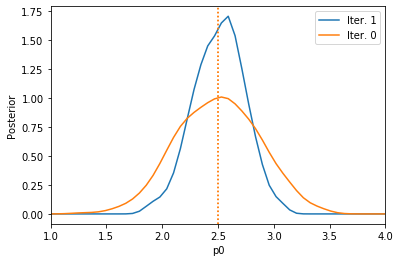

In [8]:
h = pyabc.History("sqlite:///h.db")
plot(h)

### Compute true posterior

In [9]:
def normal_dty(y, p):
    return np.prod(
        1 / np.sqrt(2*np.pi*std**2) * np.exp(-(y-p[0])**2/std**2 / 2)
    )

uniform_pd = 1 / (limits_uvar['p0'][1] - limits_uvar['p0'][0])

def posterior_unscaled(p):
    def uniform_dty(p):
        if p[0] < limits_uvar['p0'][0] or p[0] > limits_uvar['p0'][1]:
            return 0
        return uniform_pd
    return normal_dty(data['y0'], p) * uniform_dty(p)

def get_posterior_scaled():
    total = sp.integrate.quad(
        lambda p0: posterior_unscaled([p0]),
        limits_uvar['p0'][0], limits_uvar['p0'][1]
    )
    return lambda p: posterior_unscaled([p]) / total[0]

posterior = get_posterior_scaled()

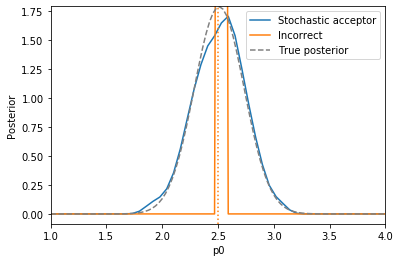

In [10]:
_, ax = plt.subplots()


#pyabc.visualization.plot_kde_1d_highlevel(h_noisy_model, x='p0', ax=ax,
#                                          xmin=limits_uvar['p0'][0], xmax=limits_uvar['p0'][1],
#                                          label="ABC noisy model posterior")
pyabc.visualization.plot_kde_1d_highlevel(h, x='p0',
                                          xmin=limits_uvar['p0'][0], xmax=limits_uvar['p0'][1],
                                          ax=ax, label="Stochastic acceptor",
                                          refval=p_true)
pyabc.visualization.plot_kde_1d_highlevel(h_incorrect, x='p0', ax=ax, t=5,
                                          xmin=limits_uvar['p0'][0], xmax=limits_uvar['p0'][1],
                                          label="Incorrect")
p0s = np.linspace(limits_uvar['p0'][0], limits_uvar['p0'][1], 100)
vals = [posterior(p0) for p0 in p0s]
ax.plot(p0s, vals, '--', label="True posterior", color='grey')

ax.legend()

plt.savefig("with_true.svg", format='svg')


#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

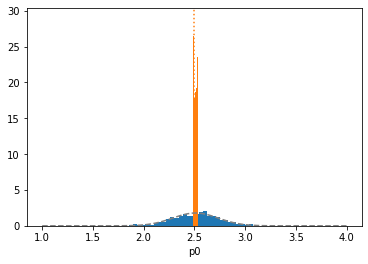

In [11]:
_, ax = plt.subplots()

pyabc.visualization.plot_histogram_1d(h, x='p0',
                                      #xmin=limits_uvar['p0'][0], xmax=limits_uvar['p0'][1],
                                      ax=ax, label="ABC stochastic acceptor posterior",
                                      refval=p_true, bins=30)
pyabc.visualization.plot_histogram_1d(h_incorrect, x='p0', ax=ax, t=5,
                                      #xmin=limits_uvar['p0'][0], xmax=limits_uvar['p0'][1],
                                      label="Incorrect ABC posterior", bins=30)
p0s = np.linspace(limits_uvar['p0'][0], limits_uvar['p0'][1], 100)
vals = [posterior(p0) for p0 in p0s]
ax.plot(p0s, vals, '--', label="True posterior", color='grey')

## Estimate noise variance

### Noisy model

In [12]:
abc = pyabc.ABCSMC(model_noisy_uvar, prior_uvar, distance, population_size=pop_size)
abc.new("sqlite:///h_noisy_model_uvar.db", data)
abc.run(max_nr_populations=8)

# note: this cell may need to be stopped if late iterations take too long

DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1
INFO:History:Start <ABCSMC(id=1, start_time=2020-01-28 22:01:17.713486, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 5.484919261426673
INFO:ABC:t: 0, eps: 5.484919261426673.
INFO:ABC:Acceptance rate: 1000 / 2107 = 4.7461e-01, ESS=1.0000e+03.
DEBUG:Epsilon:new eps, t=1, eps=2.7394424981728953
INFO:ABC:t: 1, eps: 2.7394424981728953.
INFO:ABC:Acceptance rate: 1000 / 2526 = 3.9588e-01, ESS=8.7027e+02.
DEBUG:Epsilon:new eps, t=2, eps=1.637891375115843
INFO:ABC:t: 2, eps: 1.637891375115843.
INFO:ABC:Acceptance rate: 1000 / 2939 = 3.4025e-01, ESS=7.4885e+02.
DEBUG:Epsilon:new eps, t=3, eps=1.0933605883849138
INFO:ABC:t: 3, eps: 1.0933605883849138.
INFO:ABC:Acceptance rate: 1000 / 3759 = 2.6603e-01, ESS=5.7730e+02.
DEBUG:Epsilon:new eps, t=4, eps=0.8080145188448858
INFO:ABC:t: 4, eps: 0.8080145188448858.
INFO:ABC:Acceptance rate: 1000 / 5922 = 1.6886e-01, ESS=1.2606

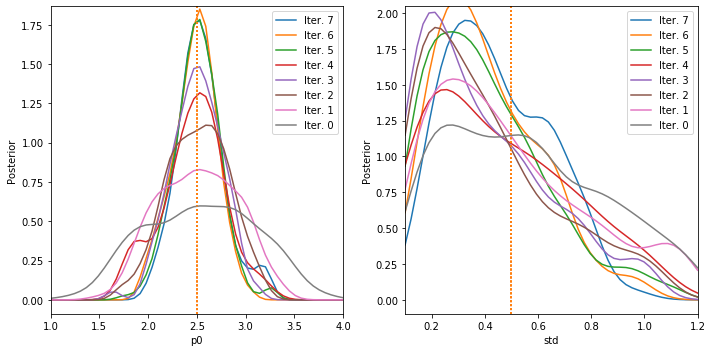

In [13]:
h_noisy_model_uvar = pyabc.History("sqlite:///h_noisy_model_uvar.db")
plot_uvar(h_noisy_model_uvar)
plt.gcf().set_size_inches((10, 5))
plt.tight_layout()

### Stochastic acceptor

In [14]:
# temperature = pyabc.Temperature(schemes=[pyabc.AcceptanceRateScheme(), pyabc.ExpDecayFixedRatioScheme()])

abc = pyabc.ABCSMC(model, prior_uvar, kernel_uvar, eps=temperature, acceptor=acceptor, population_size=pop_size)
h2 = abc.new("sqlite:///h_uvar.db", data)
h2 = abc.run()

INFO:History:Start <ABCSMC(id=1, start_time=2020-01-28 22:03:36.984895, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Acceptor:pdf_norm=-2.1363e+00 for t=0.
DEBUG:Epsilon:Proposed temperatures for 0: [4.149025776297644, inf].
INFO:ABC:t: 0, eps: 4.149025776297644.
DEBUG:Acceptor:Encountered pd=-2.1185e+00 > c=-2.1363e+00, thus weight=1.0043e+00.
DEBUG:Acceptor:Encountered pd=-2.1295e+00 > c=-2.1363e+00, thus weight=1.0017e+00.
DEBUG:Acceptor:Encountered pd=-2.1104e+00 > c=-2.1363e+00, thus weight=1.0063e+00.
DEBUG:Acceptor:Encountered pd=-2.1145e+00 > c=-2.1363e+00, thus weight=1.0053e+00.
DEBUG:Acceptor:Encountered pd=-2.1051e+00 > c=-2.1363e+00, thus weight=1.0075e+00.
INFO:ABC:Acceptance rate: 1000 / 3488 = 2.8670e-01, ESS=1.0000e+03.
DEBUG:Acceptor:pdf_norm=-2.1051e+00 for t=1.
DEBUG:Epsilon:Proposed temperatures for 1: [2.176241956247419, 2.074512888148822].
INFO:ABC:t: 1, eps: 2.074512888148822.
DEBUG:Acceptor:Encountered pd=-2.0995e+00 > c=-2.1051e+00, thus weigh

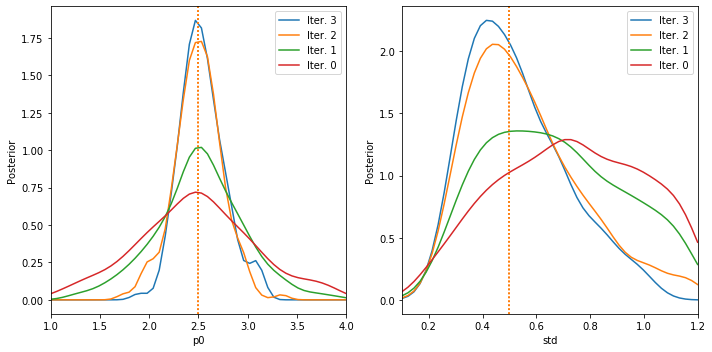

In [15]:
h_uvar = pyabc.History("sqlite:///h_uvar.db")
plot_uvar(h_uvar)
plt.gcf().set_size_inches((10, 5))
plt.tight_layout()

### Compute true posterior

In [16]:
def normal_dty(y, p):
    return np.prod(
        1 / np.sqrt(2*np.pi*p[1]**2) * np.exp(-(y-p[0])**2/p[1]**2 / 2)
    )

uniform_pd = 1 / ((limits_uvar['p0'][1] - limits_uvar['p0'][0])
                  * (limits_uvar['std'][1] - limits_uvar['std'][0]))

def posterior_unscaled(p):
    def uniform_dty(p):
        if p[0] < limits_uvar['p0'][0] or p[0] > limits_uvar['p0'][1] \
                or p[1] < limits_uvar['std'][0] or p[1] > limits_uvar['std'][1]:
            return 0
        return uniform_pd
    return normal_dty(data['y0'], p) * uniform_dty(p)

def get_posterior_scaled():
    total = sp.integrate.dblquad(
        lambda std, p0: posterior_unscaled([p0, std]),
        limits_uvar['p0'][0], limits_uvar['p0'][1],
        lambda std: limits_uvar['std'][0],
        lambda std: limits_uvar['std'][1],
    )
    return lambda p: posterior_unscaled(p) / total[0]

posterior = get_posterior_scaled()

def marg_p0(p0):
    return sp.integrate.quad(
        lambda std: posterior([p0, std]),
            limits_uvar['std'][0], limits_uvar['std'][1])[0]

def marg_std(std):
    return sp.integrate.quad(
        lambda p0: posterior([p0, std]),
            limits_uvar['p0'][0], limits_uvar['p0'][1])[0]

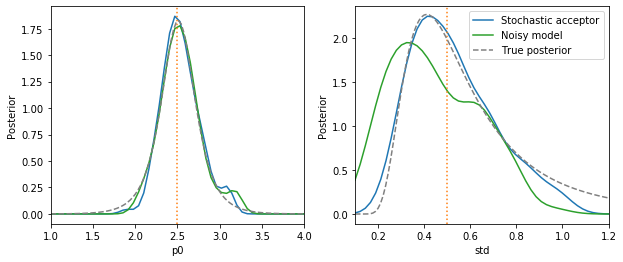

In [19]:
_, arr_ax = plt.subplots(1, 2)

for i, p in enumerate(['p0', 'std']):
    pyabc.visualization.plot_kde_1d_highlevel(h_uvar, x=p,
                                              xmin=limits_uvar[p][0], xmax=limits_uvar[p][1],
                                              ax=arr_ax[i], label="Stochastic acceptor", color='C0')
    pyabc.visualization.plot_kde_1d_highlevel(h_noisy_model_uvar, x=p, ax=arr_ax[i],
                                              xmin=limits_uvar[p][0], xmax=limits_uvar[p][1],
                                              label="Noisy model", refval=p_true_uvar, color='C2')

p0s = np.linspace(limits_uvar['p0'][0], limits_uvar['p0'][1], 100)
vals = [marg_p0(p0) for p0 in p0s]
arr_ax[0].plot(p0s, vals, '--', label="True posterior", color='grey')

p0s = np.linspace(limits_uvar['std'][0], limits_uvar['std'][1], 100)
vals = [marg_std(p0) for p0 in p0s]
arr_ax[1].plot(p0s, vals, '--', label="True posterior", color='grey')

arr_ax[1].legend()#loc='center left', bbox_to_anchor=(1, 0.5))


plt.gcf().set_size_inches((10, 4))
plt.savefig("uvar_with_true.svg", format='svg')

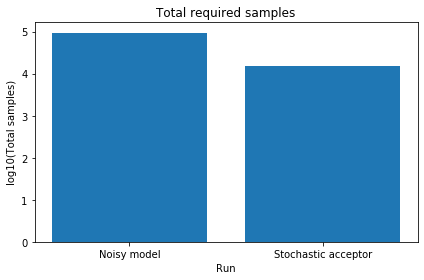

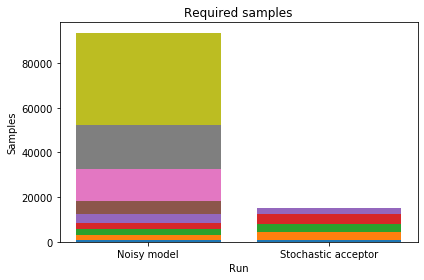

In [18]:
histories = [h_noisy_model_uvar, h_uvar]
labels = ["Noisy model", "Stochastic acceptor"]
pyabc.visualization.plot_total_sample_numbers(histories, labels, yscale="log10")
pyabc.visualization.plot_sample_numbers(histories, labels)

A strange thing to notice is that the noisy model analysis first goes for smaller variances, and has a hard time converging to the true distribution, while the stochastic acceptor has no such problems.